# BED File

In [ ]:
# Import necessary modules
from collections import defaultdict
import re
import HTSeq

# Read the genomic intervals from the BED file 'LCT.bed' using HTSeq.BED_Reader
lct_bed = HTSeq.BED_Reader('LCT.bed')

# Create a defaultdict to count the occurrences of different feature types
feature_types = defaultdict(int)

# Loop through each record (genomic interval) in the 'lct_bed' object
for rec in lct_bed:
    last_rec = rec  # Store the last record to access it later
    # Extract the feature type from the 'name' attribute using regular expression and update the counter
    feature_types[re.search('([A-Z]+)', rec.name).group(0)] += 1

print("Feature types and their occurrences:")
print(feature_types)

# Print information about the last record in the BED file
print("Information about the last record:")
print("Last Record:", last_rec)
print("Last Record Name:", last_rec.name)
print("Type of Last Record:", type(last_rec))
interval = last_rec.iv
print("Interval of Last Record:", interval)
print("Type of Interval:", type(interval))

# Print specific information about the genomic interval of the last record
print("Chromosome, Start, and End of Interval:")
print(interval.chrom, interval.start, interval.end)
print("Strand of Interval:", interval.strand)
print("Length of Interval:", interval.length)
print("Start Position Description:", interval.start_d)
print("Start Position as Position Object:", interval.start_as_pos)
print("Type of Start Position as Position Object:", type(interval.start_as_pos))

# Analyze exons from the BED file
exon_start = None
exon_end = None
sizes = []
for rec in lct_bed:
    # Skip records that do not start with 'CCDS' (not exons)
    if not rec.name.startswith('CCDS'):
        continue
    interval = rec.iv
    # Update the exon_start and exon_end with the minimum start and maximum end position among exons
    exon_start = min(interval.start, exon_start or interval.start)
    exon_end = max(interval.end, exon_end or interval.end)
    sizes.append(interval.length)

sizes.sort()
# Print statistics about the exons
print("Exon Statistics:")
print("Number of Exons:", len(sizes))
print("Exon Start Position:", exon_start)
print("Exon End Position:", exon_end)
print("Smallest Exon Length:", sizes[0])
print("Largest Exon Length:", sizes[-1])
print("Mean Exon Length: %.1f" % (sum(sizes) / len(sizes)))

# BAM

In [ ]:
# Import necessary modules
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pysam

# Open the BAM file in read mode
bam = pysam.AlignmentFile('NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam', 'rb')

# Extract and print headers from the BAM file
headers = bam.header
for record_type, records in headers.items():
    print (record_type)
    for i, record in enumerate(records):
        if type(record) == dict:
            print('\t%d' % (i + 1))
            for field, value in record.items():
                print('\t\t%s\t%s' % (field, value))
        else:
            print('\t\t%s' % record)

# Find and print the first mapped read with both 'M' (match) and 'S' (soft clip) in the CIGAR string
for rec in bam:
    if rec.cigarstring.find('M') > -1 and rec.cigarstring.find('S') > -1 and not rec.is_unmapped and not rec.mate_is_unmapped:
        break
print("First Read Name:", rec.query_name)
print("Reference ID:", rec.reference_id)
print("Reference Name:", bam.getrname(rec.reference_id))
print("Reference Start:", rec.reference_start)
print("Reference End:", rec.reference_end)
print("CIGAR String:", rec.cigarstring)
print("Query Alignment Start:", rec.query_alignment_start)
print("Query Alignment End:", rec.query_alignment_end)
print("Query Alignment Length:", rec.query_alignment_length)
print("Next Reference ID:", rec.next_reference_id)
print("Next Reference Start:", rec.next_reference_start)
print("Template Length:", rec.template_length)
print("Is Paired?:", rec.is_paired)
print("Is Proper Pair?:", rec.is_proper_pair)
print("Is Unmapped?:", rec.is_unmapped)
print("Mapping Quality:", rec.mapping_quality)
print("Query Qualities:", rec.query_qualities)
print("Query Alignment Qualities:", rec.query_alignment_qualities)
print("Query Sequence:", rec.query_sequence)

# Calculate the percentage of mapped calls as a function of the position from the start of the sequencer read
counts = [0] * 76
for n, rec in enumerate(bam.fetch('20', 0, 10000000)):
    for i in range(rec.query_alignment_start, rec.query_alignment_end):
        counts[i] += 1
freqs = [100 * x / (n + 1) for x in counts]
fig, ax = plt.subplots(figsize=(16, 9), dpi=300, tight_layout=True)
ax.plot(range(1, 77), freqs)
ax.set_xlabel('Read distance', fontsize='xx-large')
ax.set_ylabel('PHRED score', fontsize='xx-large')
fig.suptitle('Percentage of mapped calls as a function of the position from the start of the sequencer read', fontsize='xx-large')
fig.savefig('map_perc.png')

# Calculate the distribution of PHRED scores as a function of the position in the read
phreds = defaultdict(list)
for rec in bam.fetch('20', 0, None):
    for i in range(rec.query_alignment_start, rec.query_alignment_end):
        phreds[i].append(rec.query_qualities[i])

maxs = [max(phreds[i]) for i in range(76)]
tops = [np.percentile(phreds[i], 95) for i in range(76)]
medians = [np.percentile(phreds[i], 50) for i in range(76)]
bottoms = [np.percentile(phreds[i], 5) for i in range(76)]
medians_fig = [x - y for x, y in zip(medians, bottoms)]
tops_fig = [x - y for x, y in zip(tops, medians)]
maxs_fig = [x - y for x, y in zip(maxs, tops)]

fig, ax = plt.subplots(figsize=(16, 9), dpi=300, tight_layout=True)
ax.stackplot(range(1, 77), (bottoms, medians_fig, tops_fig, maxs_fig))
ax.plot(range(1, 77), maxs, 'k-')
ax.set_xlabel('Read distance', fontsize='xx-large')
ax.set_ylabel('PHRED score', fontsize='xx-large')
fig.suptitle('Distribution of PHRED scores as a function of the position in the read', fontsize='xx-large')
fig.savefig('phred2.png')

# Fastq

SRR003265.31 SRR003265.31 3042NAAXX:3:1:1252:1819 length=51 GGGAAAAGAAAAACAAACAAACAAAAACAAAACACAGAAACAAAAAAACCA
{'phred_quality': [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 30, 23, 40, 32, 35, 29, 40, 16, 40, 40, 32, 35, 31, 40, 40, 39, 22, 40, 24, 20, 28, 31, 12, 31, 10, 22, 28, 13, 26, 20, 23, 23]}
G: 20.68 5359334
A: 28.60 7411965
C: 21.00 5444053
T: 29.58 7666885
N: 0.14 37289
40: 22.76 3007221
16: 2.05 270431
32: 1.03 136763
35: 0.91 120704
31: 1.08 142464
39: 0.78 102568
22: 1.59 209905
24: 1.46 193259
20: 1.73 228923
28: 1.23 162226
12: 2.35 309918
10: 4.95 654154
13: 2.28 301033
26: 1.33 176263
23: 1.52 201164
37: 0.84 111179
34: 0.95 125624
21: 1.66 219602
30: 1.13 149449
33: 0.99 131291
25: 1.40 184846
17: 1.97 259779
38: 0.80 106290
4: 4.77 630923
36: 0.88 115701
18: 1.88 248982
11: 2.41 318303
19: 1.81 239621
5: 4.88 645266
9: 2.51 332259
3: 4.04 533458
27: 1.28 168902
8: 2.53 334410
29: 1.17 154892
15: 2.12 280719
7: 2.51 331743
2: 3.77 49

FileNotFoundError: [Errno 2] No such file or directory: 'SRR003265_1.filt.fastq.gz'

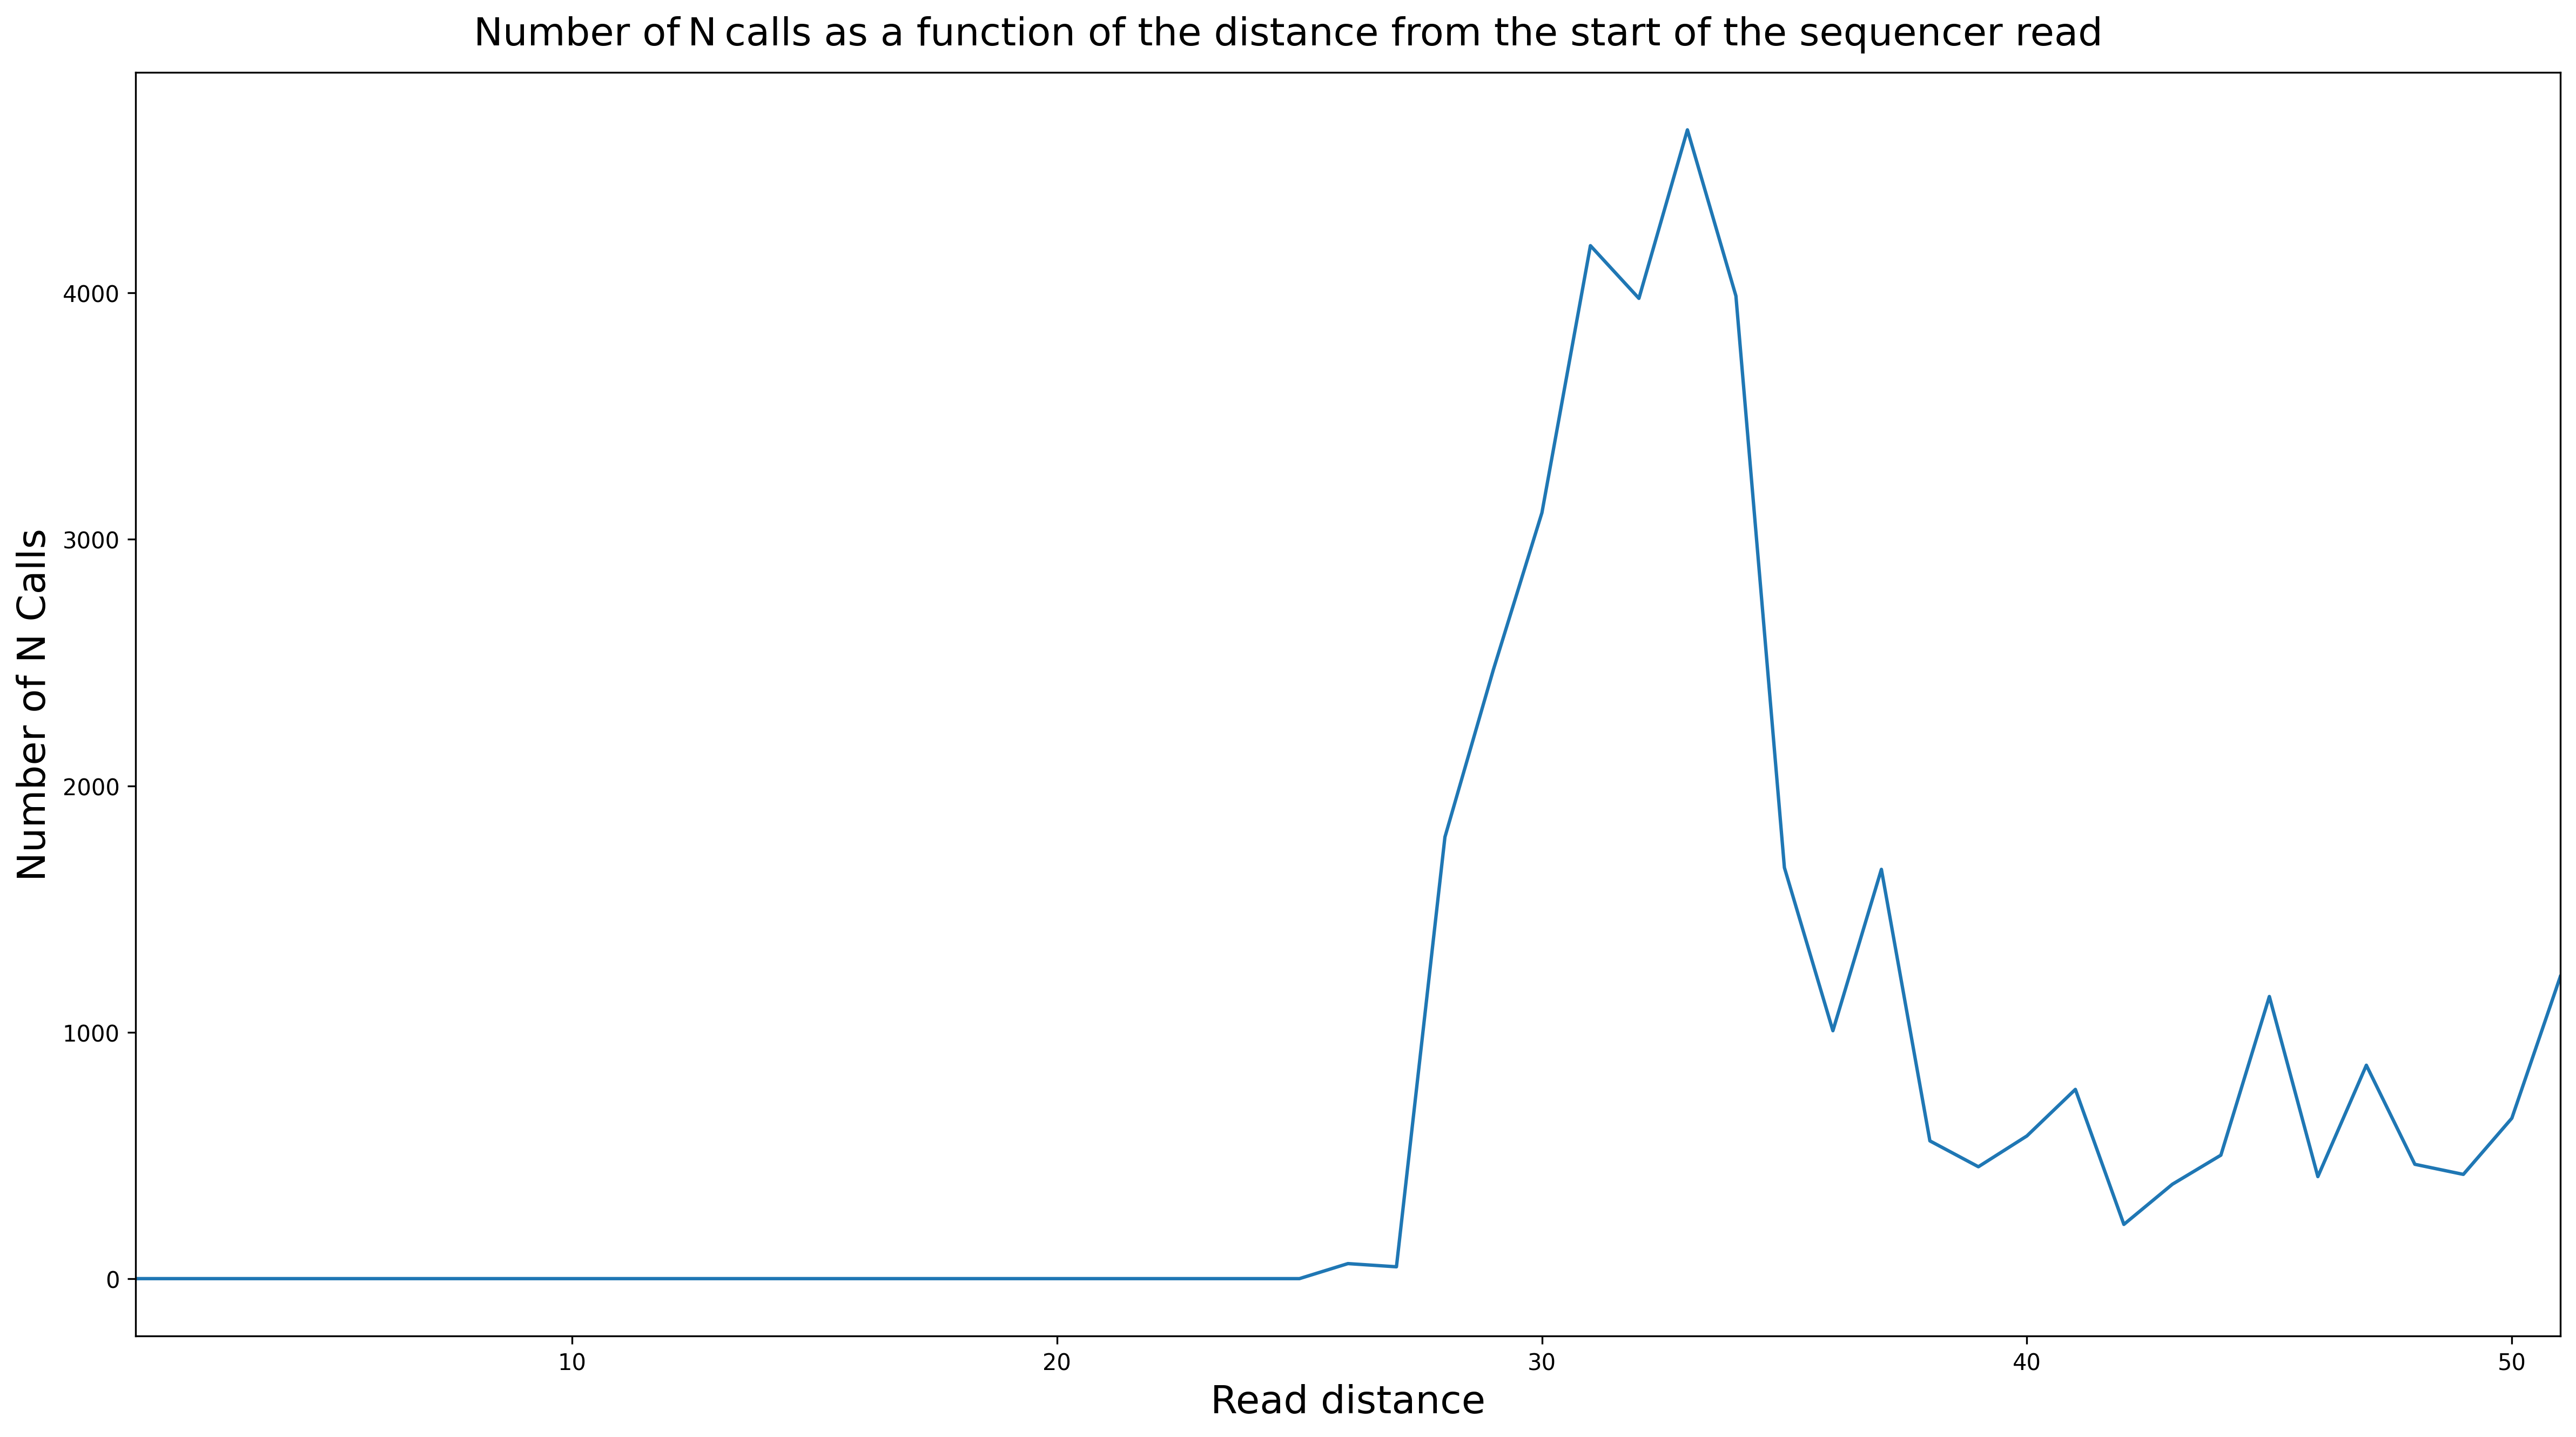

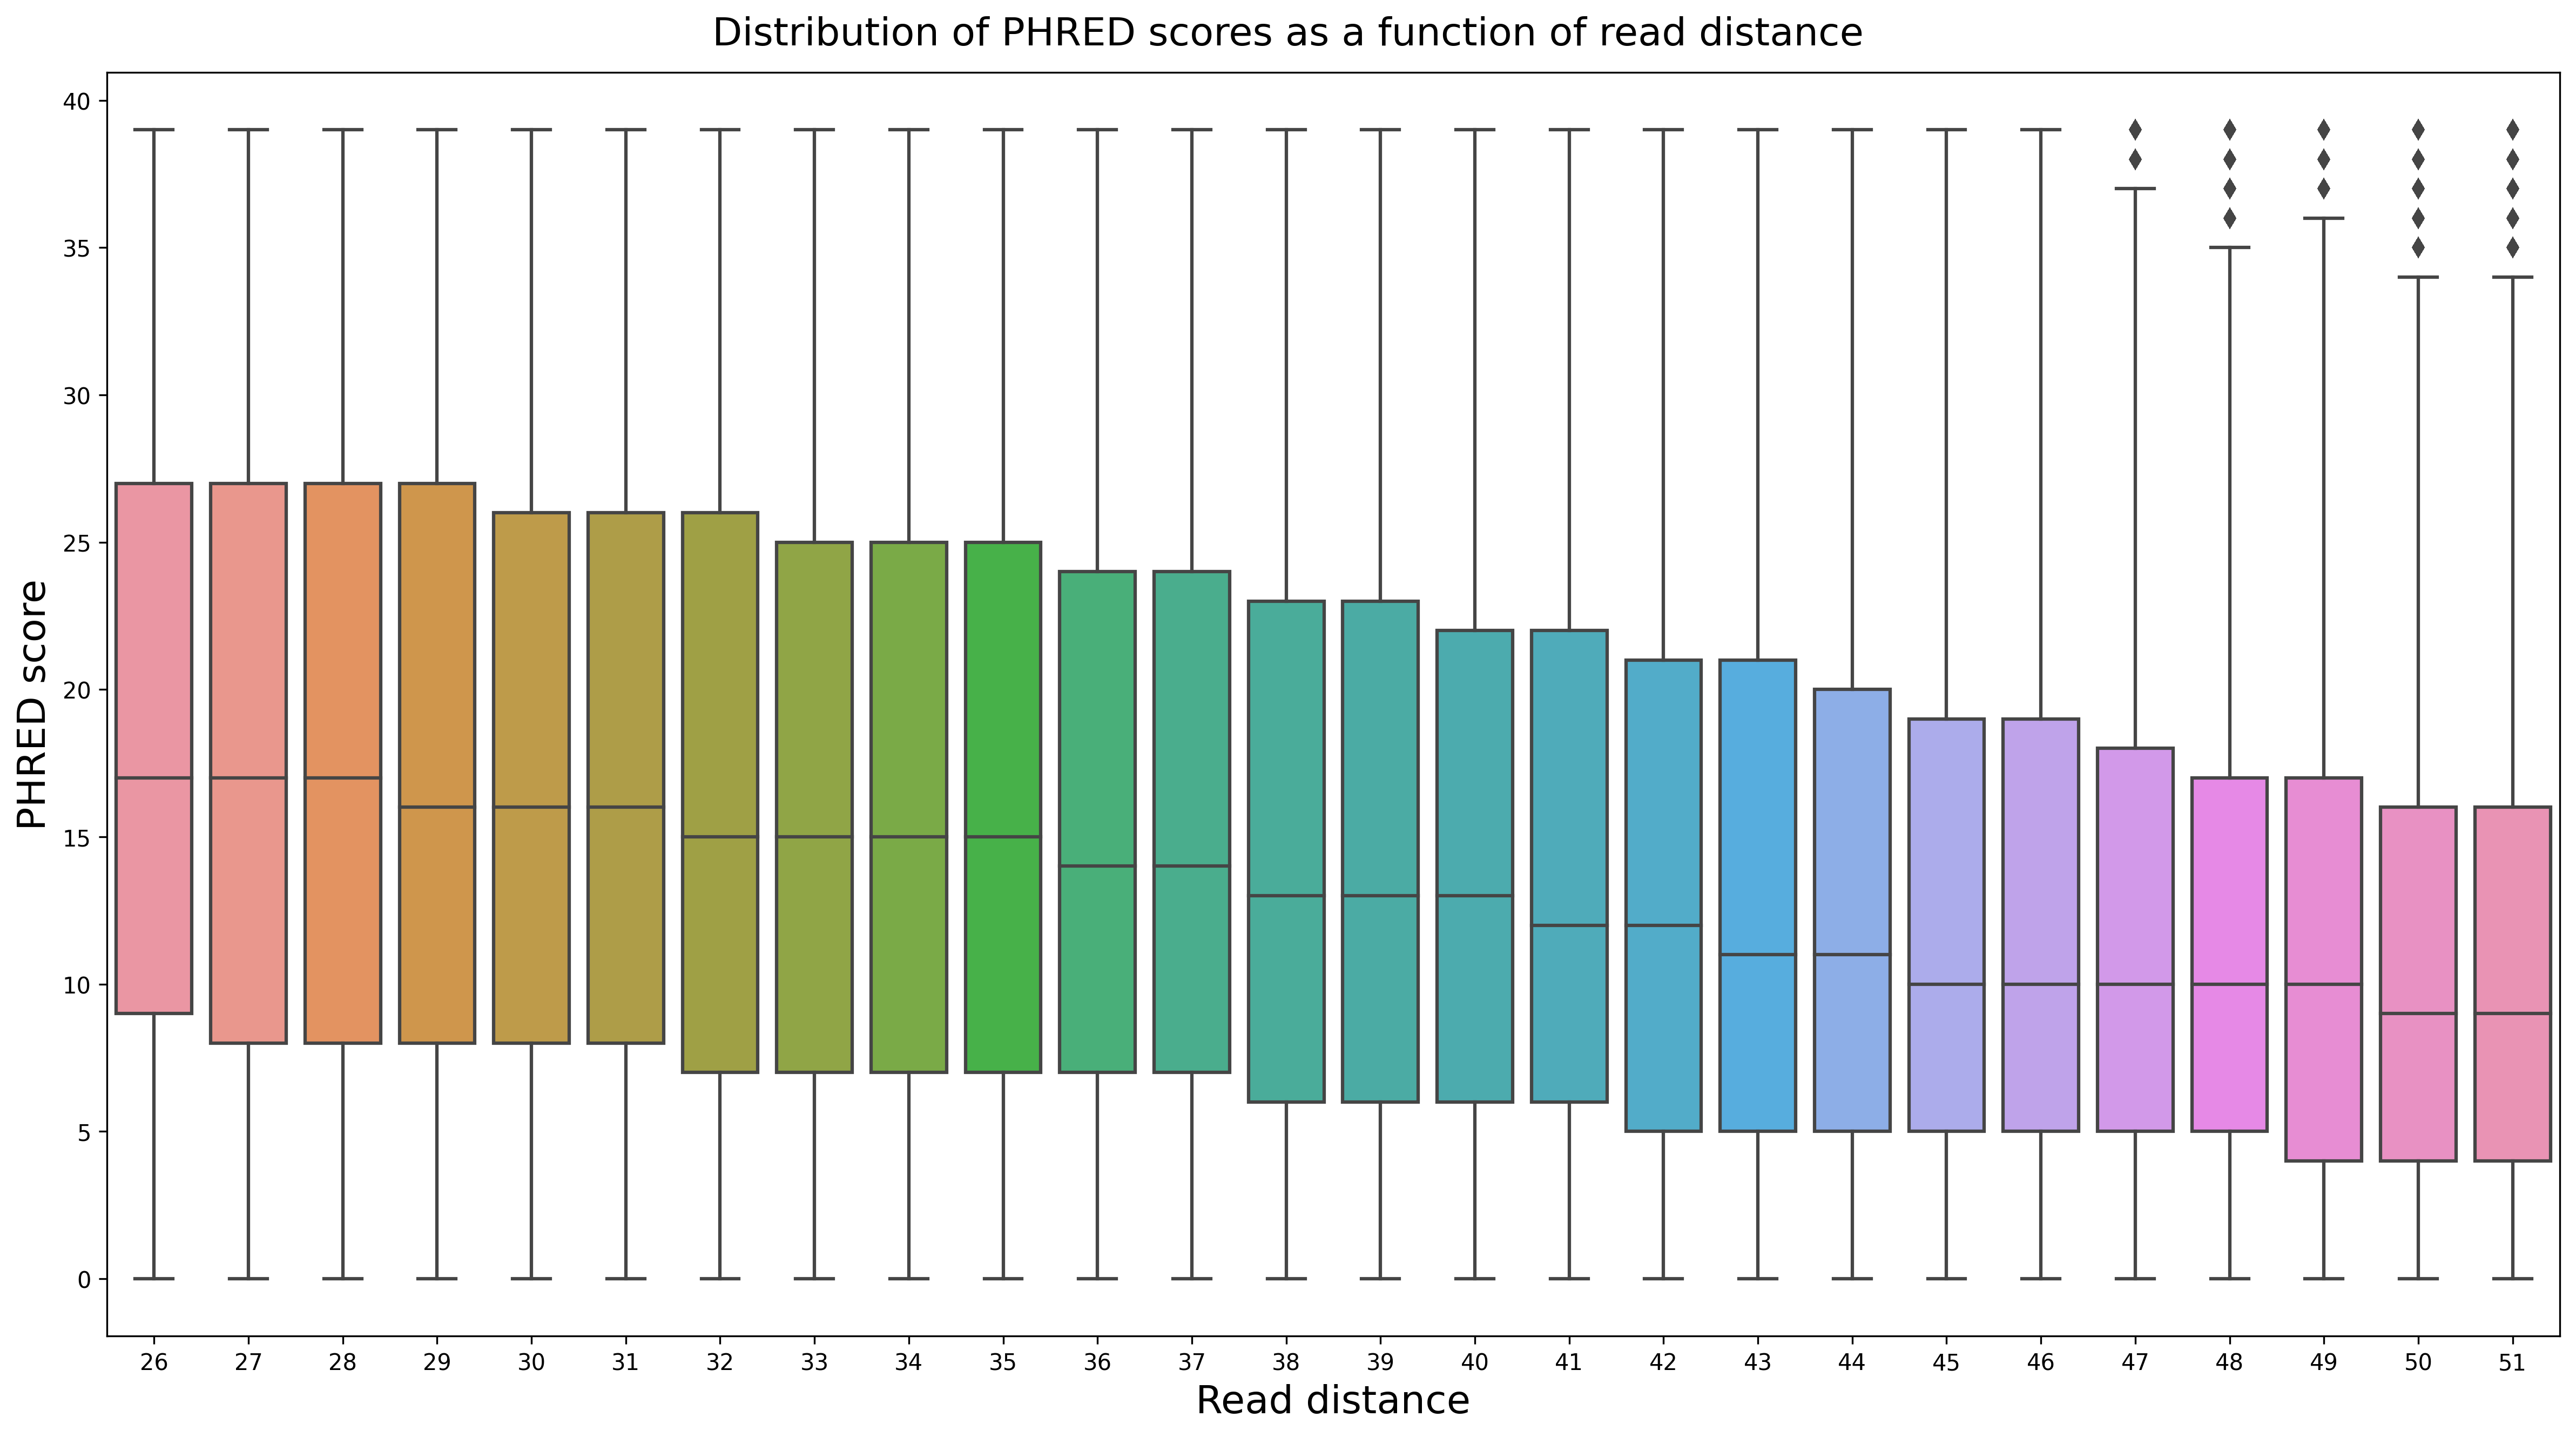

In [4]:
# Import necessary modules
from collections import defaultdict
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO

# Open the FASTQ file and parse the records
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')

# Extract and print the first record's ID, description, and sequence along with its letter annotations (quality scores)
rec = next(recs)
print("ID:", rec.id)
print("Description:", rec.description)
print("Sequence:", rec.seq)
print("Letter Annotations (Quality Scores):", rec.letter_annotations)

# Calculate the percentage of each letter in the sequences
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
cnt = defaultdict(int)
for rec in recs:
    for letter in rec.seq:
        cnt[letter] += 1
tot = sum(cnt.values())
for letter, cnt in cnt.items():
    print('%s: %.2f %d' % (letter, 100 * cnt / tot, cnt))

# Calculate the number of 'N' calls as a function of the distance from the start of the sequencer read and plot the results
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='UTF-8'), 'fastq')
n_cnt = defaultdict(int)
for rec in recs:
    for i, letter in enumerate(rec.seq):
        pos = i + 1
        if letter == 'N':
            n_cnt[pos] += 1
seq_len = max(n_cnt.keys())
positions = range(1, seq_len + 1)
fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True, dpi=300)
fig.suptitle('Number of N calls as a function of the distance from the start of the sequencer read', fontsize='xx-large')
ax.plot(positions, [n_cnt[x] for x in positions])
ax.set_xlim(1, seq_len)
ax.set_xlabel('Read distance', fontsize='xx-large')
ax.set_ylabel('Number of N Calls', fontsize='xx-large')
fig.savefig('n_calls.png')

# Calculate the distribution of PHRED scores as a function of the position in the read and plot the results
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
cnt_qual = defaultdict(int)
for rec in recs:
    for i, qual in enumerate(rec.letter_annotations['phred_quality']):
        if i < 25:
            continue
        cnt_qual[qual] += 1
tot = sum(cnt_qual.values())
for qual, cnt in cnt_qual.items():
    print('%d: %.2f %d' % (qual, 100. * cnt / tot, cnt))

recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
qual_pos = defaultdict(list)
for rec in recs:
    for i, qual in enumerate(rec.letter_annotations['phred_quality']):
        if i < 25 or qual == 40:
            continue
        pos = i + 1
        qual_pos[pos].append(qual)
vps = []
poses = list(qual_pos.keys())
poses.sort()
for pos in poses:
    vps.append(qual_pos[pos])
fig, ax = plt.subplots(figsize=(16, 9), dpi=300, tight_layout=True)
sns.boxplot(data=vps, ax=ax)
ax.set_xticklabels([str(x) for x in range(26, max(qual_pos.keys()) + 1)])
ax.set_xlabel('Read distance', fontsize='xx-large')
ax.set_ylabel('PHRED score', fontsize='xx-large')
fig.suptitle('Distribution of PHRED scores as a function of read distance', fontsize='xx-large')
fig.savefig('phred.png')


# VCF

In [ ]:
# Import necessary modules
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from cyvcf2 import VCF

# Read and process variant level information from the 'snps.vcf' file
v = VCF('snps.vcf')
rec = next(v)
print('Variant Level information')
info = rec.INFO
for info in rec.INFO:
    print(info)

print('Sample Level information')
for fmt in rec.FORMAT:
    print(fmt)

# Read and process variant data from the 'genotypes.vcf.gz' file
v = VCF('genotypes.vcf.gz')
samples = v.samples
print(len(samples))  # Order change

variant = next(v)
print(variant.CHROM, variant.POS, variant.ID, variant.REF, variant.ALT, variant.QUAL, variant.FILTER)
print(variant.INFO)
print(variant.FORMAT)
print(variant.is_snp)

# Extract genotype information for the first variant
str_alleles = variant.gt_bases[0]
alleles = variant.genotypes[0][0:2]
is_phased = variant.genotypes[0][2]
print(str_alleles, alleles, is_phased)
print(variant.format('DP')[0])

# Analyze and print the variant types and counts
f = VCF('genotypes.vcf.gz')
my_type = defaultdict(int)
num_alts = defaultdict(int)

for variant in f:
    my_type[variant.var_type, variant.var_subtype] += 1
    if variant.var_type == 'snp':
        num_alts[len(variant.ALT)] += 1
print(my_type)
print(num_alts)

# Analyze and plot the distribution of depth (DP) for SNP variants
f = VCF('genotypes.vcf.gz')
sample_dp = defaultdict(int)
for variant in f:
    if not variant.is_snp or len(variant.ALT) != 1:
        continue
    for dp in variant.format('DP'):
        sample_dp[dp] += 1

dps = list(sample_dp.keys())
dps.sort()
dp_dist = [sample_dp[x] for x in dps]
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(dp_dist[:50], 'r')
ax.axvline(dp_dist.index(max(dp_dist)))
